### CASTOR's Candidate Legacy Survey Maps
This notebook shows a plot of the CASTOR Legacy Surveys that have contiguous fields.
And an animation illustrating CASTOR's viewing efficiency across different regions of the sky throughout the year. 

In [1]:
import numpy as np

def normalize_ra(ra):
    """
    Normalizes a Right Ascension (RA) value to the range [-180°, 180°].
    
    Parameters
    ----------
    ra : float
        Right Ascension coordinate in degrees.
    """
    while ra >= 180:
        ra -= 360
    while ra < -180:
        ra += 360
    return ra


def split_boundary(boundary_coords):
    """
    Split a footprint boundary that crosses -180° and 180° in RA into two separate fields. 
    This ensures the boundary does not wrap around when plotting the footprint on a survey 
    map with RA values constrained to the range [-180°, 180°].
    
    Parameters
    ----------
    boundary_coords : numpy.ndarray or list
        An array of footprint boundary coordinates as (ra, dec) in degrees.
        Note: RA values are within the [-180, 180] range.
    
    Returns
    -------
    field1 : numpy.ndarray
        The part of the field that terminates at RA = -180°. 
        
    field2 : numpy.ndarray
        The part of the field that terminates at RA = 180°. 
    """
    field1, field2 = [], []
    
    for i in range(len(boundary_coords) - 1):
        ra1, dec1 = boundary_coords[i]
        ra2, dec2 = boundary_coords[i + 1]
        
        # Check if crossing the boundary
        if abs(ra1 - ra2) > 180:
            # Interpolate the crossing point
            ra_cross = 180 if ra1 < ra2 else -180
            dec_cross = dec1 + (dec2 - dec1) * ((ra_cross - ra1) / (ra2 - ra1))
            
            # Clip the crossing point to avoid wraparounds
            ra_cross_clipped = 179.9 if ra_cross == 180 else -179.9
            
            # Assign to the respective field
            if ra_cross == 180:
                # Crossing from negative to positive
                field1.append((ra1, dec1))
                field1.append((-179.9, dec_cross))
                field2.append((179.9, dec_cross))
                field2.append((ra2, dec2))
            else:
                # Crossing from positive to negative
                field2.append((ra1, dec1))
                field2.append((179.9, dec_cross))
                field1.append((-179.9, dec_cross))
                field1.append((ra2, dec2))
        else:
            # Assign based on RA value
            if ra1 < 0:
                field1.append((ra1, dec1))
            else:
                field2.append((ra1, dec1))
    
    # Ensure each field boundary is closed
    if field1:
        field1.append(field1[0])
    if field2:
        field2.append(field2[0])
    
    return np.array(field1), np.array(field2)
    

def create_circle(cx, cy, r, num=50):
    """
    Generates the boundary points of a circle.

    Parameters
    ----------
    cx : float
        The x-coordinate of the circle's center.

    cy : float
        The y-coordinate of the circle's center.

    r : float
        The radius of the circle.

    num : int, optional, default=50
        The number of points used to approximate the circle's boundary.

    Returns
    -------
    boundary : numpy.ndarray
        An array of tuples representing the points outlining the circle.
    """
    increment = 2*np.pi / num
    boundary = []
    
    for i in range(num):
        angle = i * increment
        x = cx + r * np.cos(angle)
        y = cy + r * np.sin(angle)
        boundary.append((x, y))
        
    boundary.append(boundary[0]) 
    return np.array(boundary)


def ecliptic_to_equatorial(lamdas):
    """
    Finds the Right Ascension corresponding to each ecliptic longitude (lamda). 
    
    Note: on Vernal Equinox, lamda = 0°, which means the anti-sun direction 
    will be lamda = -180°. 

    Parameters
    ----------
    lamdas : numpy.ndarray or list
        An array of "Sun" ecliptic longitude values in degrees. 

    Returns
    -------
    RAs : list
        A list of corresponding R.A. values in degrees.
    """
    RAs = []
    for lamda in lamdas:
        RAs.append(
            lamda + 2.45 * np.sin(np.radians(2 * lamda))
        )
    return RAs
    

# From the `utilities.py` script
def hms_to_deg(hr, min, sec):
    """
    Convert Right Ascension from HMS (hours, minutes, seconds) J2000 format to degrees 
    in the range [-180°, 180°].
    """
    degrees = (hr + min / 60 + sec / 3600) * 15
    while degrees >= 180:
        degrees -= 360
    while degrees < -180:
        degrees += 360
    return degrees


def dms_to_deg(deg, arcmin, arcsec):
    """
    Convert Declination from DMS (degrees, arcminutes, arcseconds) J2000 format to degrees.
    """
    if deg < 0:
        degrees = -(abs(deg) + arcmin / 60 + arcsec / 3600)
    else:
        degrees = deg + arcmin / 60 + arcsec / 3600
    return degrees

In [2]:
import numpy as np
from astropy.coordinates import SkyCoord

# Define the CASTOR Square Kilodegree Galactic Plane Survey Footprint Boundary

# The footprint vertices (in galactic coordinates)
l = [-74, -74, -10, -10, 10, 10, 60, 60, 10, 10, -10, -10, -74]
b = [-3, 3, 3, 10, 10, 3, 3, -3, -3, -10, -10, -3, -3]

l_coords = []
b_coords = []

# Iterate through each pair of vertices
for i in range(len(l) - 1):
    l_start, l_end = l[i], l[i + 1]
    b_start, b_end = b[i], b[i + 1]
    
    # Interpolate points between the vertices
    l_segment = np.linspace(l_start, l_end, 100)
    b_segment = np.linspace(b_start, b_end, 100)
    
    if i == 0:
        l_coords.extend(l_segment)
        b_coords.extend(b_segment)
    else:
        l_coords.extend(l_segment[1:])
        b_coords.extend(b_segment[1:])

# Convert the galactic coordinates to the ICRS equatorial coordinates
galactic = SkyCoord(l=l_coords, b=b_coords, frame="galactic", unit="deg").icrs

# Normalize RA values to the range [-180°, 180°]
galactic_footprint = np.array(
    [(normalize_ra(ra), dec) for ra, dec in zip(galactic.ra.deg, galactic.dec.deg)]
)

# Save as a text file
np.savetxt('Galactic_footprint.txt', galactic_footprint, header='RA	DEC', fmt='%f')

#### Viewing Zone Animation

runtime: 58.209320625290275 sec


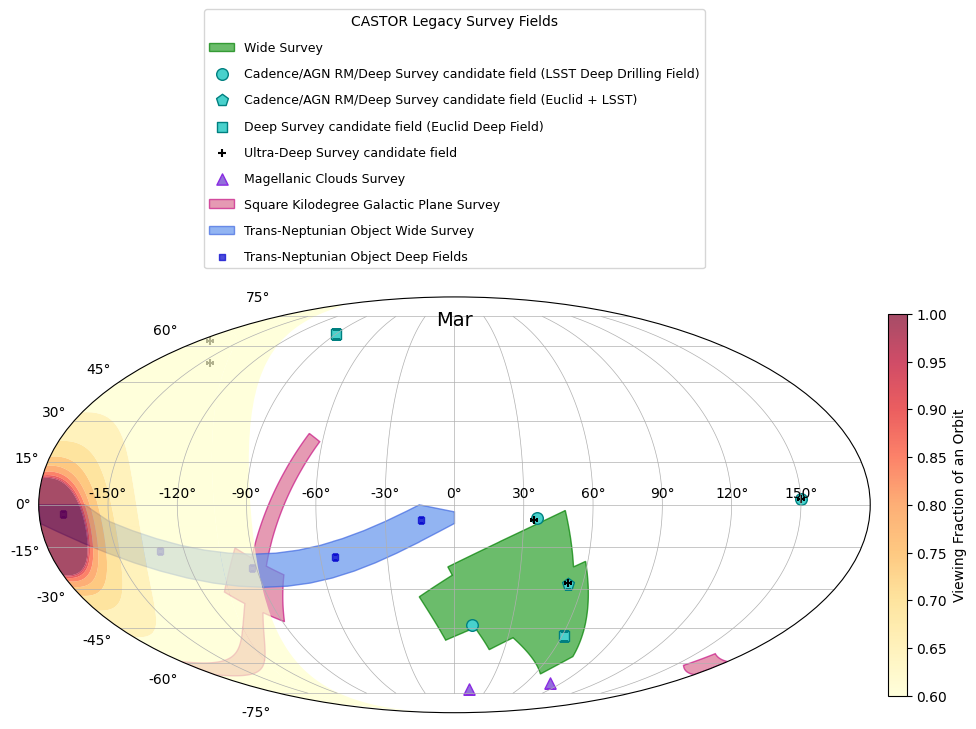

In [3]:
import numpy as np
import matplotlib
import matplotlib.patches as p
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from shapely.geometry import Polygon, box
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# CASTOR Legacy Survey field coordinates

# CASTOR Wide Survey
Wide = np.loadtxt('Wide_footprint.txt')

# CASTOR Cadence Survey + AGN RM Survey + Deep Survey
# Rubin/ LSST Deep Drilling Fields
ELAIS_S1 = (hms_to_deg(0, 37, 48), dms_to_deg(-44, 0, 0))
XMM_LSS = (hms_to_deg(2, 22, 50), dms_to_deg(-4, 45, 0))
ECDFS = (hms_to_deg(3, 32, 30), dms_to_deg(-28, 6, 0)) # Euclid also
COSMOS = (hms_to_deg(10, 0, 24), dms_to_deg(2, 10, 55)) # Euclid also

# CASTOR Deep Survey
# Euclid Deep Fields
EDFN = (hms_to_deg(17, 58, 56), dms_to_deg(66, 1, 3.7))
EDFS = (hms_to_deg(4, 4, 58), dms_to_deg(-48, 25, 23))
# CASTOR Ultra Deep Candidate Fields
COSMOS_ultra = (hms_to_deg(10, 0, 28), dms_to_deg(2, 12, 4))
EGS = (hms_to_deg(14, 19, 18), dms_to_deg(52, 49, 30))
GOODS_S = (hms_to_deg(3, 32, 29), dms_to_deg(-27, 48, 18))
GOODS_N = (hms_to_deg(12, 36, 55), dms_to_deg(62, 14, 19))
UDS = (hms_to_deg(2, 17, 37), dms_to_deg(-5, 12, 0))

# CASTOR Magellanic Cloud Survey
LMC = (hms_to_deg(5, 23, 34), dms_to_deg(-69, 45, 22))
SMC = (hms_to_deg(0, 52, 45), dms_to_deg(-72, 49, 43))

# CASTOR Square Kilodegree Galactic Plane Survey
Galactic = np.loadtxt('Galactic_footprint.txt')
# split the footprint to avoid wraparounds
Galactic1, Galactic2 = split_boundary(Galactic)

# CASTOR Trans-Neptunian Objects (TNO) Survey
# TNO Wide Survey
TNO_wide = np.loadtxt('TNO_wide_footprint.txt')
# TNO Deep Survey
xmin, ymin, xmax, ymax = Polygon(TNO_wide).bounds
xDeep = np.linspace(xmin+10, xmax-15, 5)
yDeep = np.array([-3, -16, -22, -18, -5])

# Set up the main plot
fig, ax = plt.subplots(figsize=(9.88, 7.8), subplot_kw={'projection': 'mollweide'})
plt.subplots_adjust(left=0.2, right=0.95, top=0.55, bottom=0.03)
ax.grid(True, linewidth=0.5, zorder=0) 

""" Plot the survey fields """
ax.add_patch(
    p.Polygon(
        np.radians(Wide), facecolor='tab:green', alpha=0.7, edgecolor='green', 
        label='Wide Survey'
    )
)

ax.scatter(
    np.radians(ELAIS_S1[0]), np.radians(ELAIS_S1[1]), marker='o', s=70, color='mediumturquoise', ec='teal', 
    label='Cadence/AGN RM/Deep Survey candidate field (LSST Deep Drilling Field)'
)
ax.scatter(
    np.radians(XMM_LSS[0]), np.radians(XMM_LSS[1]), marker='o', s=70, color='mediumturquoise', ec='teal'
)

ax.scatter(
    np.radians(ECDFS[0]), np.radians(ECDFS[1]), marker='p', s=80, color='mediumturquoise', ec='teal',
    label='Cadence/AGN RM/Deep Survey candidate field (Euclid + LSST)'
)
ax.scatter(
    np.radians(COSMOS[0]), np.radians(COSMOS[1]), marker='o', s=70, color='mediumturquoise', ec='teal'
)

ax.scatter(
    np.radians(EDFN[0]), np.radians(EDFN[1]), marker='s', s=60, color='mediumturquoise', ec='teal', 
    label='Deep Survey candidate field (Euclid Deep Field)'
)
ax.scatter(
    np.radians(EDFS[0]), np.radians(EDFS[1]), marker='s', s=60, color='mediumturquoise', ec='teal'
)

ax.scatter(
    np.radians(COSMOS_ultra[0]), np.radians(COSMOS_ultra[1]), marker='+', s=40, color='black', 
    label='Ultra-Deep Survey candidate field'
)
ax.scatter(np.radians(EGS[0]), np.radians(EGS[1]), marker='+', s=40, color='black')
ax.scatter(np.radians(GOODS_S[0]), np.radians(GOODS_S[1]), marker='+', s=40, color='black')
ax.scatter(np.radians(GOODS_N[0]), np.radians(GOODS_N[1]), marker='+', s=40, color='black')
ax.scatter(np.radians(UDS[0]), np.radians(UDS[1]), marker='+', s=40, color='black')


ax.scatter(
    np.radians(LMC[0]), np.radians(LMC[1]), marker='^', s=65, color='mediumpurple', ec='blueviolet', 
    label='Magellanic Clouds Survey'
)
ax.scatter(
    np.radians(SMC[0]), np.radians(SMC[1]), marker='^', s=65, color='mediumpurple', ec='blueviolet'
)

ax.add_patch(
    p.Polygon(
        np.radians(Galactic1), facecolor='palevioletred', edgecolor='mediumvioletred', alpha=0.7,
        label='Square Kilodegree Galactic Plane Survey'
    )
)
ax.add_patch(
    p.Polygon(
        np.radians(Galactic2), facecolor='palevioletred', edgecolor='mediumvioletred', alpha=0.7
    )
)

ax.add_patch(
    p.Polygon(
        np.radians(TNO_wide), facecolor='cornflowerblue', edgecolor='royalblue', alpha=0.7,
        label='Trans-Neptunian Object Wide Survey'
    )
)
ax.scatter(
    np.radians(xDeep + 0.4), np.radians(yDeep - 0.4), marker='s', s=20, color='mediumblue', alpha=0.7,
    label='Trans-Neptunian Object Deep Fields'
)

plt.legend(
    title="CASTOR Legacy Survey Fields", loc='center', 
    bbox_to_anchor=(0.5, 1.38), fontsize=9, labelspacing=1.05
)

""" Define the CVZ position at each month """
# Generate a list of anti-sun directions in ecliptic longitudes 
# which represents the telescope's Continuous Viewing Zone (CVZ) direction 
# on each day, starting from the Vernal Equinox (assuming to be March 21st)
lamdas = np.arange(-180, 180, step=360 / 365.25)

# The daily Right Ascension of the CVZ center starting on March 21st. 
CVZ_path = ecliptic_to_equatorial(lamdas)

# First day of every month starting on Apr 1st.
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
index = [11, 41, 72, 102, 133, 164, 194, 225, 255, 286, 317, 345]

# Find the month corresponding to the Right Ascension (RA) value 
# where the Continuous Viewing Zone (CVZ) center is located.
month_positions = np.radians([CVZ_path[i] for i in index])
# Add the month label text at the top of the plot, initially blank
month_text = ax.text(0, np.radians(70), '', color='black', fontsize=14, ha='center')
# Initial month
current_month = 'Mar'

""" Define the CVZ and the viewing efficiency contours """
# Viewing Efficiency Data
radii_data = [17.3, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
view_frac_data = [1, 0.912784936, 0.867195243, 0.835480674, 0.811694747, 0.791873142, 0.775024777, 0.761149653, 
                  0.74826561, 0.727452924, 0.702675917, 0.673934589, 0.653121903, 0.638255699, 0.627353816, 
                  0.618434093, 0.611496531, 0.60654113, 0.602576809, 0.599603568, 0.597621407, 0.596630327, 0.595639247]
view_frac = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
radii = [np.interp(vf, view_frac_data[::-1], radii_data[::-1]) for vf in view_frac]
view_frac.append(0.6)
radii.append(90)

# Normalize the viewing fractions for the color map
norm = Normalize(vmin=min(view_frac), vmax=max(view_frac))
cmap = plt.get_cmap('YlOrRd')
# Define the ScalarMappable for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Set the initial viewing zone position
x_position = -180  # start at the left edge of the map
step = 2

# Store viewing zone patches
viewing_zones = []
# Function to create and plot the viewing zones
def plot_viewzone():
    # Plot concentric rings based on the radii and viewing fractions
    for i, r in enumerate(radii):
        color = cmap(norm(view_frac[i]))
        alpha = 0.7
        if i == 0:
            # Circle at the center
            circle_outline = create_circle(np.radians(x_position), np.radians(-7.8), np.radians(r), num=100)
            zone_patch = ax.fill(circle_outline[:,0], circle_outline[:,1], color=color, ec=None, alpha=alpha)[0]
            viewing_zones.append(zone_patch)  # Store the patch for removal later
        else:
            # Outer rings
            inner_circle = Polygon(create_circle(np.radians(x_position), np.radians(-7.8), np.radians(radii[i-1]), num=100))
            outer_circle = Polygon(create_circle(np.radians(x_position), np.radians(-7.8), np.radians(r), num=100))
            ring = outer_circle.difference(inner_circle)
            # Separate the ring into top and bottom halves
            xmin, ymin, xmax, ymax = ring.bounds
            cut_above = box(xmin, np.radians(-7.8), xmax, ymax)
            cut_below = box(xmin, ymin, xmax, np.radians(-7.8))
            top_half = ring.difference(cut_below)
            bottom_half = ring.difference(cut_above)
            # Plot the halves
            for half in [top_half, bottom_half]:
                x_half, y_half = half.exterior.xy
                zone_patch = ax.fill(x_half, y_half, color=color, ec=None, alpha=alpha)[0]
                viewing_zones.append(zone_patch)  # Store the patch for removal later

def animate(i):
    global x_position, current_month  
    # Update the x-position of the viewing zone 
    x_position += step  # Move right by 'step' degrees each frame 
    if x_position > 180:  # Reset position if it goes off-screen
        x_position = -180
    
    # Clear previous viewing zones
    for zone in viewing_zones:
        zone.remove()  # Remove the old viewing zone patches
    viewing_zones.clear()  # Clear the list of patches

    # Update the viewing zone with the new x-position
    plot_viewzone()

    # Initialize a variable to track if a month change occurred
    month_changed = False
    # Check if circle center is close to any month position
    for j, month_x in enumerate(month_positions):
        if abs(np.radians(x_position) - month_x) < np.radians(2):  # 2-degree tolerance
            if current_month != month[j]:  # Update only if the month has changed
                current_month = month[j]
                month_text.set_text(current_month)  # Update month text
                month_changed = True  # Indicate a change has occurred
            break
    # If no month change was detected, keep the current month displayed
    if not month_changed:
        month_text.set_text(current_month)

    return viewing_zones, month_text

import timeit
code_start = timeit.default_timer()

# Create the animation
ani = FuncAnimation(fig, animate, frames=np.arange(0, 360, step), interval=200)

# Add the color bar below the Mollweide plot
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', alpha=0.7, pad=0.02, fraction=0.022)
cbar.set_label("Viewing Fraction of an Orbit")
cbar.set_ticks(view_frac[:-1])
cbar.set_ticklabels([f"{vf:.2f}" for vf in view_frac[:-1]])
plt.tight_layout()

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128  # for large animations
# Display the animation
# HTML(ani.to_jshtml())
# Save the animation
writergif = matplotlib.animation.PillowWriter(fps=15)
ani.save('legacy_surveys.gif', writer=writergif, dpi=150)  # increase dpi for higher quality image

runtime = timeit.default_timer() - code_start
print(f"runtime: {runtime} sec")

#### Survey Map

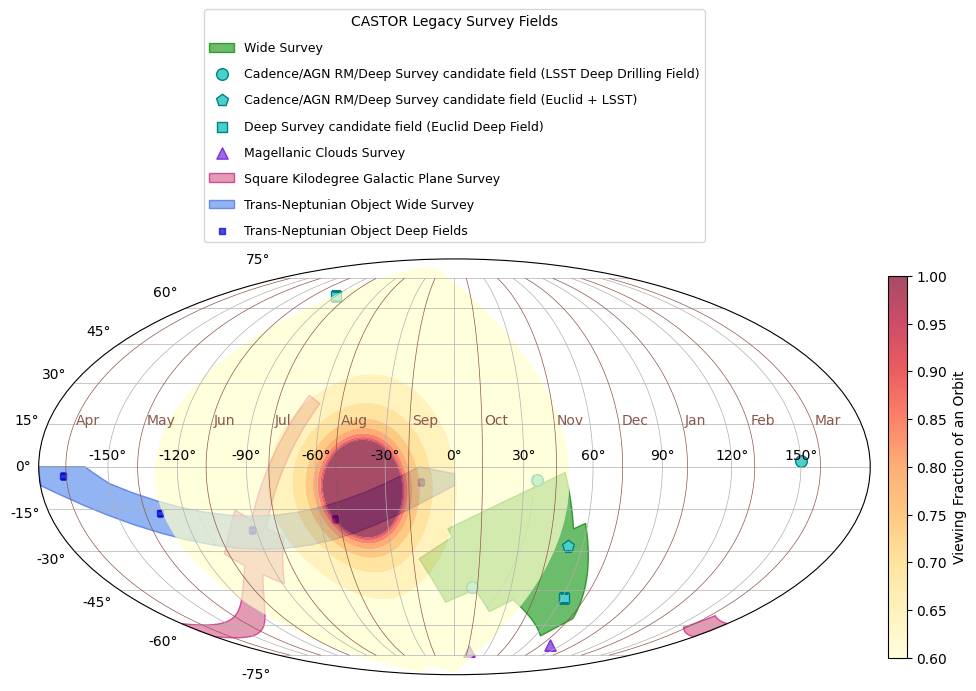

In [4]:
import numpy as np
import matplotlib.patches as p
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from shapely.geometry import Polygon, box

# CASTOR Legacy Survey field coordinates

# CASTOR Wide Survey
Wide = np.loadtxt('Wide_footprint.txt')

# CASTOR Cadence Survey + AGN RM Survey + Deep Survey
# Rubin/ LSST Deep Drilling Fields
ELAIS_S1 = (hms_to_deg(0, 37, 48), dms_to_deg(-44, 0, 0))
XMM_LSS = (hms_to_deg(2, 22, 50), dms_to_deg(-4, 45, 0))
ECDFS = (hms_to_deg(3, 32, 30), dms_to_deg(-28, 6, 0)) # Euclid also
COSMOS = (hms_to_deg(10, 0, 24), dms_to_deg(2, 10, 55)) # Euclid also

# CASTOR Deep Survey
# Euclid Deep Fields
EDFN = (hms_to_deg(17, 58, 56), dms_to_deg(66, 1, 3.7))
EDFS = (hms_to_deg(4, 4, 58), dms_to_deg(-48, 25, 23))
# CASTOR Ultra Deep Candidate Fields
COSMOS_ultra = (hms_to_deg(10, 0, 28), dms_to_deg(2, 12, 4))
EGS = (hms_to_deg(14, 19, 18), dms_to_deg(52, 49, 30))
GOODS_S = (hms_to_deg(3, 32, 29), dms_to_deg(-27, 48, 18))
GOODS_N = (hms_to_deg(12, 36, 55), dms_to_deg(62, 14, 19))
UDS = (hms_to_deg(2, 17, 37), dms_to_deg(-5, 12, 0))

# CASTOR Magellanic Cloud Survey
LMC = (hms_to_deg(5, 23, 34), dms_to_deg(-69, 45, 22))
SMC = (hms_to_deg(0, 52, 45), dms_to_deg(-72, 49, 43))

# CASTOR Square Kilodegree Galactic Plane Survey
Galactic = np.loadtxt('Galactic_footprint.txt')
# split the footprint to avoid wraparounds
Galactic1, Galactic2 = split_boundary(Galactic)

# CASTOR Trans-Neptunian Objects (TNO) Survey
# TNO Wide Survey
TNO_wide = np.loadtxt('TNO_wide_footprint.txt')
# TNO Deep Survey
xmin, ymin, xmax, ymax = Polygon(TNO_wide).bounds
xDeep = np.linspace(xmin+10, xmax-15, 5)
yDeep = np.array([-3, -16, -22, -18, -5])


# Set up the main plot
fig, ax = plt.subplots(figsize=(9.88, 7.3), subplot_kw={'projection': 'mollweide'})
plt.subplots_adjust(left=0.2, right=0.95, top=0.55, bottom=0.03)
ax.grid(True, linewidth=0.5, zorder=0) 

""" Plot the CVZ path throughout the year """
# Generate a list of anti-sun directions in ecliptic longitudes 
# which represents the telescope's Continuous Viewing Zone (CVZ) direction 
# on each day, starting from the Vernal Equinox (assuming to be March 21st)
lamdas = np.arange(-180, 180, step=360 / 365.25)

# The daily Right Ascension of the CVZ center starting on March 21st. 
CVZ_path = ecliptic_to_equatorial(lamdas)

# First day of every month starting on Apr 1st.
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
index = [11, 41, 72, 102, 133, 164, 194, 225, 255, 286, 317, 345]

# Plot the month corresponding to the Right Ascension (RA) value 
# where the Continuous Viewing Zone (CVZ) center is located.
for i, name in zip(index, month):
    plt.axvline(x=np.radians(CVZ_path[i]), color='tab:brown', linewidth=0.5)
    ax.text(np.radians(CVZ_path[i] + 1), np.radians(15), name, color='tab:brown')

""" Plot the survey fields """
ax.add_patch(
    p.Polygon(
        np.radians(Wide), facecolor='tab:green', alpha=0.7, edgecolor='green', 
        label='Wide Survey'
    )
)

ax.scatter(
    np.radians(ELAIS_S1[0]), np.radians(ELAIS_S1[1]), marker='o', s=70, color='mediumturquoise', ec='teal', 
    label='Cadence/AGN RM/Deep Survey candidate field (LSST Deep Drilling Field)'
)
ax.scatter(
    np.radians(XMM_LSS[0]), np.radians(XMM_LSS[1]), marker='o', s=70, color='mediumturquoise', ec='teal'
)

ax.scatter(
    np.radians(ECDFS[0]), np.radians(ECDFS[1]), marker='p', s=80, color='mediumturquoise', ec='teal',
    label='Cadence/AGN RM/Deep Survey candidate field (Euclid + LSST)'
)
ax.scatter(
    np.radians(COSMOS[0]), np.radians(COSMOS[1]), marker='o', s=70, color='mediumturquoise', ec='teal'
)

ax.scatter(
    np.radians(EDFN[0]), np.radians(EDFN[1]), marker='s', s=60, color='mediumturquoise', ec='teal', 
    label='Deep Survey candidate field (Euclid Deep Field)'
)
ax.scatter(
    np.radians(EDFS[0]), np.radians(EDFS[1]), marker='s', s=60, color='mediumturquoise', ec='teal'
)

# ax.scatter(
#     np.radians(COSMOS_ultra[0]), np.radians(COSMOS_ultra[1]), marker='+', s=40, color='black', 
#     label='Ultra-Deep Survey candidate field'
# )
# ax.scatter(np.radians(EGS[0]), np.radians(EGS[1]), marker='+', s=40, color='black')
# ax.scatter(np.radians(GOODS_S[0]), np.radians(GOODS_S[1]), marker='+', s=40, color='black')
# ax.scatter(np.radians(GOODS_N[0]), np.radians(GOODS_N[1]), marker='+', s=40, color='black')
# ax.scatter(np.radians(UDS[0]), np.radians(UDS[1]), marker='+', s=40, color='black')


ax.scatter(
    np.radians(LMC[0]), np.radians(LMC[1]), marker='^', s=65, color='mediumpurple', ec='blueviolet', 
    label='Magellanic Clouds Survey'
)
ax.scatter(
    np.radians(SMC[0]), np.radians(SMC[1]), marker='^', s=65, color='mediumpurple', ec='blueviolet'
)

ax.add_patch(
    p.Polygon(
        np.radians(Galactic1), facecolor='palevioletred', edgecolor='mediumvioletred', alpha=0.7,
        label='Square Kilodegree Galactic Plane Survey'
    )
)
ax.add_patch(
    p.Polygon(
        np.radians(Galactic2), facecolor='palevioletred', edgecolor='mediumvioletred', alpha=0.7
    )
)

ax.add_patch(
    p.Polygon(
        np.radians(TNO_wide), facecolor='cornflowerblue', edgecolor='royalblue', alpha=0.7,
        label='Trans-Neptunian Object Wide Survey'
    )
)
ax.scatter(
    np.radians(xDeep + 0.4), np.radians(yDeep - 0.4), marker='s', s=20, color='mediumblue', alpha=0.7,
    label='Trans-Neptunian Object Deep Fields'
)

plt.legend(
    title="CASTOR Legacy Survey Fields", loc='center', 
    bbox_to_anchor=(0.5, 1.32), fontsize=9, labelspacing=1.05
)

""" Plot the CVZ and the viewing efficiency contours """
# Viewing Efficiency Data
radii_data = [17.3, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
view_frac_data = [1, 0.912784936, 0.867195243, 0.835480674, 0.811694747, 0.791873142, 0.775024777, 0.761149653, 
                  0.74826561, 0.727452924, 0.702675917, 0.673934589, 0.653121903, 0.638255699, 0.627353816, 
                  0.618434093, 0.611496531, 0.60654113, 0.602576809, 0.599603568, 0.597621407, 0.596630327, 0.595639247]
view_frac = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
radii = [np.interp(vf, view_frac_data[::-1], radii_data[::-1]) for vf in view_frac]
view_frac.append(0.6)
radii.append(90)

# Normalize the viewing fractions for the color map
norm = Normalize(vmin=min(view_frac), vmax=max(view_frac))
cmap = plt.get_cmap('YlOrRd')
# Define the ScalarMappable for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot concentric rings based on the radii and viewing fractions
x_position = -40
for i, r in enumerate(radii):
    color = cmap(norm(view_frac[i]))
    alpha = 0.7
    if i == 0:
        # Circle at the center
        circle_outline = create_circle(np.radians(x_position), np.radians(-7.8), np.radians(r), num=100)
        ax.fill(circle_outline[:,0], circle_outline[:,1], color=color, ec=None, alpha=alpha)
    else:
        # Outer rings
        inner_circle = Polygon(create_circle(np.radians(x_position), np.radians(-7.8), np.radians(radii[i-1]), num=100))
        outer_circle = Polygon(create_circle(np.radians(x_position), np.radians(-7.8), np.radians(r), num=100))
        ring = outer_circle.difference(inner_circle)
        # Separate the ring into top and bottom halves
        xmin, ymin, xmax, ymax = ring.bounds
        cut_above = box(xmin, np.radians(-7.8), xmax, ymax)
        cut_below = box(xmin, ymin, xmax, np.radians(-7.8))
        top_half = ring.difference(cut_below)
        bottom_half = ring.difference(cut_above)
        # Plot the halves
        for half in [top_half, bottom_half]:
            x_half, y_half = half.exterior.xy
            ax.fill(x_half, y_half, color=color, ec=None, alpha=alpha)

# Add the color bar below the Mollweide plot
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', alpha=alpha, pad=0.02, fraction=0.022)
cbar.set_label("Viewing Fraction of an Orbit")
cbar.set_ticks(view_frac[:-1])
cbar.set_ticklabels([f"{vf:.2f}" for vf in view_frac[:-1]])
plt.tight_layout()
# plt.savefig('legacy_surveys.pdf')

plt.show()